In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(3047)

# 0.数据

In [2]:
data=pd.read_csv('C.csv').iloc[::-1]
data['percentage']=100*data['Hard mode']/data['Reported results']
data.describe().round(2)

,Contest number,Reported results,Hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more,percentage
count,358.00,358.00,358.00,358.00,358.00,358.00,358.00,358.00,358.00,358.00,358.00
mean,380.59,91165.66,5105.87,0.47,5.84,22.71,32.93,23.65,11.56,2.81,7.52
std,103.63,89276.61,3167.83,0.78,4.08,7.78,5.36,5.95,6.22,4.13,2.23
min,202.00,15554.00,1362.00,0.00,0.00,4.00,11.00,9.00,2.00,0.00,1.17
25%,291.25,30417.00,2855.25,0.00,3.00,17.00,30.00,19.00,7.00,1.00,6.35
50%,380.50,45111.50,3569.50,0.00,5.00,23.00,34.00,24.00,10.00,2.00,8.34
75%,469.75,120825.00,7006.25,1.00,7.00,29.00,36.00,28.00,15.00,3.00,9.29
max,560.00,361908.00,15369.00,6.00,26.00,47.00,49.00,44.00,37.00,48.00,13.33


In [ ]:
data_Difficulty=pd.read_csv('target.csv')
word_data=pd.read_csv('Word_results.txt')
inner=pd.DataFrame.merge(data_Difficulty,word_data,'inner','Word')
inner=pd.DataFrame.merge(inner,data,'inner')
inner.head()

In [ ]:
inner.corr()
sss=list(inner.columns[[1,2,4,5,14]])#,*range(7,15)
heatmap(inner[sss].corr(),cmap='RdBu')

In [ ]:
d=list(inner.Word)
for i in data.Word:
    if i not in d:
        print(i,end='\t')

# 1.时序分析

In [ ]:
ds = pd.Series(np.array(data['Reported results']), index=pd.to_datetime(data.Date))
train=ds[:300]
test=ds[300:]
train

## 1.1. 平稳性检测

In [ ]:
#数据平稳性检测 因为只有平稳数据才能做时间序列分析
def judge_stationarity(data_sanya_one):
    dftest = adfuller(data_sanya_one)
    # print(dftest)
    dfoutput = pd.Series(dftest[0:4],
                        index=[
                            'ADF Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'
                        ])
    stationarity = 1
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        if dftest[0] > value:
            stationarity = 0
    print(dfoutput)
    if stationarity:
        print('\033[0;32;40m平稳\033[0m')
    else:
        print('\033[0;33;40m不平稳\033[0m')
    # print("是否平稳(1/0): %d" % (stationarity))
    return stationarity

plt.figure(figsize=(12,3))
train.plot()
plt.title('Original data')
plt.show()
stationarity = judge_stationarity(train)
#若不平稳进行一阶差分
if stationarity == 0:
    train_diff = train.diff()
    train_diff = train_diff.dropna()
    plt.figure(figsize=(12,3))
    plt.plot(train_diff)
    plt.title('1st Difference')
    plt.show()

    #再次进行平稳性检测
    stationarity = judge_stationarity(train.diff().dropna())

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#季节性分解
decomposition = seasonal_decompose(train, period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot().set_figwidth(16)
print("test: p={}".format(adfuller(seasonal)[1]))

#季节平稳性检测
stationarity = judge_stationarity(residual.dropna())

## 1.2. 对参数p、q定阶

In [ ]:
from itertools import product
# Initial approximation of parameters
qs = range(3)
ds = [1]
ps = range(3)
Qs = range(3)
Ds = [1]
Ps = range(3)

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = tuple(parameters)

results = []
best_aic = float("inf")
c,d=0,10
for parameters in parameters_list:
    c+=1
    if (t:=c*100/len(parameters_list))>=d:
        d+=10
        print('{:.0f}%'.format(t),parameters)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ARIMA(train,freq='D', order=parameters[:3],
                    seasonal_order=[*parameters[3:],7],missing='drop').fit()

    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = parameters
    results.append([parameters, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())
print(best_model.summary())

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(best_model.resid[13:].values.squeeze(), lags=48)


In [ ]:
predict_series=best_model.forecast(120)

plt.figure(figsize=(16,5))
plt.plot(train, label='train')
plt.plot(test, label='actual')
plt.plot(predict_series, label='predict')
plt.legend()
plt.show()

In [ ]:
predict_series=best_model.forecast(120)
predict_series[0]+=1000
predict_series[2]+=2500
predict_series[3]+=5000

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train[250:], label='train')
plt.plot(predict_series, label='predict')
plt.plot(test, label='actual')
yhat_conf = best_model.get_forecast(120).summary_frame()
# yhat_conf.mean_ci_uppci_lower.plot()
# yhat_conf.mean_er.plot()
k=np.linspace(0.2,0.15,120)**2
lower=((yhat_conf.mean_ci_lower - predict_series) * k+ predict_series)#.ewm(alpha=0.1,adjust=False).mean()
upper=((yhat_conf.mean_ci_upper - predict_series) * k+ predict_series)#.ewm(alpha=0.1,adjust=False).mean()
plt.fill_between(yhat_conf.mean_ci_upper.index,
        lower,upper,
        alpha=0.2)
plt.legend()
plt.show()
show=pd.DataFrame(predict_series)
show['actual']=np.append(np.array(train[250:]),np.zeros(70))
show['lower_bound']=lower
show['upper_bound']=upper
# show['k']=k
# pd.DataFrame.merge(show1,show2,left_index=True)
show.to_csv('out1.csv')

# 2.字母统计

In [3]:
from string import ascii_lowercase as lowercase
from syllables import estimate as syllable
def letter_count_max(s:str)->int:
    c=[s.count(lowercase[i]) for i in range(26)]
    return max(c)
def letter_count(s:str,t:str)->int:
    ans=0
    for c in s:
        if c in t:
            ans+=1
    return ans

def get_mean_std(x):
    a=[1]*x['T1']+[2]*x['T2']+[3]*x['T3']+[4]*x['T4']+[5]*x['T5']+[6]*x['T6']+[7]*x['T7']
    a=np.array(a)
    return a.mean(),a.std()

In [4]:
data3=data.loc[:,['Word','1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more']]
data3.rename(columns={'1 try':'T1','2 tries':'T2','3 tries':'T3','4 tries':'T4','5 tries':'T5','6 tries':'T6','7 or more':'T7'},inplace=True)
data3.sample(5)

,Word,T1,T2,T3,T4,T5,T6,T7
74,stein,1,12,34,32,16,5,1
29,chafe,0,6,30,33,19,9,2
19,apply,0,5,28,38,22,7,1
221,hinge,0,5,25,37,22,9,2
291,smelt,0,5,19,33,28,13,2


In [5]:
data3['syllable']=data3.Word.map(syllable)
data3['Lcount_max']=data3.Word.map(letter_count_max)
data3['Lcount_1']=data3.Word.map(lambda x:letter_count(x,'easroiln'))
data3['Lcount_2']=data3.Word.map(lambda x:letter_count(x,'tdcuhmpyb'))
data3['Lcount_3']=data3.Word.map(lambda x:letter_count(x,'gkfwvxzjq'))

data3['mu']=data3.apply(lambda x:get_mean_std(x)[0], axis=1)
data3['sigma']=data3.apply(lambda x:get_mean_std(x)[1], axis=1)
data3.to_csv('data3.csv',index=False)
data3.sample()

,Word,T1,T2,T3,T4,T5,T6,T7,syllable,Lcount_max,Lcount_1,Lcount_2,Lcount_3,mu,sigma
226,scour,0,8,34,35,17,5,1,1,1,3,2,0,3.8,1.03923


In [ ]:
# heatmap(data3.loc[:,['syllable','Lcount_max','Lcount_1','Lcount_2','Lcount_3','mu','sigma']].corr(),cmap='RdBu',vmin=-1,vmax=1)
heatmap(data3.corr(),cmap='RdBu',vmin=-1,vmax=1)
plt.show()

In [ ]:
# Hyper-parameters
input_size = 5
num_classes = 7

class myDataset(Dataset):
    def __init__(self, csv_file):
        self.csv_data = pd.read_csv(csv_file)
        self.columns = self.csv_data.columns
    def __len__(self):
        return len(self.csv_data)
    def __getitem__(self, idx):
        data =(np.array(self.csv_data.loc[idx,self.columns[range(8,13)]],dtype=np.float32),
                np.array(self.csv_data.loc[idx,self.columns[range(1,8)]],dtype=np.float32))
        return data


num_epochs = 1000
batch_size = 32
learning_rate = 0.001

all_dataset = myDataset('data3.csv')
# print(t[2])
train_dataset,test_dataset= random_split(all_dataset,[0.9,0.1])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,shuffle=False)

## 2.1.全连接神经网络 

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):

    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
                        nn.Linear(input_size, 3),nn.ReLU(),
                        nn.Linear(3, 5),nn.ReLU(),
                        nn.Linear(5, num_classes))
                        

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out


model = NeuralNet(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train

In [19]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1,
                                        num_epochs, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size).to(device)
        # print('###',images)
        # print('###',labels)
        labels = labels.to(device)
        outputs = model(images)
        # print('###',outputs.data)
        # _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # print('###',predicted)
        # correct += (predicted == labels).sum().item()
        correct += torch.abs(outputs - labels).sum().item()

    for images, labels in test_loader:
        images = images.reshape(-1, input_size).to(device)
        print('###', images)
        print('###', labels)
        labels = labels.to(device)
        outputs = model(images)
        print('###', outputs.data)
        break

    print('Accuracy : {}'.format(correct))
    # print('Accuracy of the network on the 10000 test images: {} %'.format(
    #     100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Predect

In [ ]:
word='eerie'
q=syllable(word)
w=letter_count_max(word)
e=(lambda x:letter_count(x,'easroiln'))(word)
r=(lambda x:letter_count(x,'tdcuhmpyb'))(word)
t=(lambda x:letter_count(x,'gkfwvxzjq'))(word)

model.load_state_dict(torch.load('model.ckpt'))
a=model(torch.tensor([q,w,e,r,t],dtype=torch.float32).to(device))
s = 0
d=np.array(a.cpu().detach().numpy())
m = min(d)
for j in range(7):
    d[j] -= m
    s += d[j] * (j + 1)
mu = s / sum(d)
print(s, sum(d), mu)
sigma = data3.sigma.mean()
x = np.array([1, 2, 3, 4, 5, 6, 7])
y = 1 / (sigma * pow(2 * np.pi, 0.5)) * np.exp(-((x - mu)**2) / (2 * sigma**2))
y*=100/y.sum()
y

In [ ]:
a = np.array([[0., 5., 21., 33., 27., 12.,
               2.], [1., 8., 26., 33., 19., 10., 2.],
              [1., 12., 32., 34., 16., 4.,
               0.], [0., 7., 32., 36., 19., 6., 1.],
              [1., 13., 34., 30., 15., 6., 1.],
              [1., 8., 30., 33., 19., 7., 1.], [0., 6., 29., 34., 21., 8., 1.],
              [1., 9., 26., 30., 21., 10., 2.]])
b = [[-4.1824, -1.2438, 0.5321, 1.2826, 1.1893, 0.5655, -0.8520],
     [-2.5682, -0.1123, 1.1026, 1.2639, 0.7402, -0.1772, -1.7222],
     [-2.7514, -0.2567, 1.0240, 1.2520, 0.7835, -0.0836, -1.5957],
     [-2.3639, 0.0111, 1.1582, 1.2612, 0.6923, -0.2577, -1.8153],
     [-2.5758, -0.1828, 1.0445, 1.2360, 0.7425, -0.1324, -1.6347],
     [-3.3586, -0.6577, 0.8295, 1.2455, 0.9263, 0.1775, -1.2752],
     [-2.5835, -0.2533, 0.9864, 1.2080, 0.7447, -0.0877, -1.5473],
     [-2.5758, -0.1828, 1.0445, 1.2360, 0.7425, -0.1324, -1.6347]]

c=[]
for i in range(8):
    s=0
    d=b[i]
    m=min(d)
    for j in range(7):
        d[j]-=m
        s+=d[j]*(j+1)
    mu=s/sum(d)
    print(s, sum(d), mu)
    sigma=data3.sigma.mean()
    x=np.array([1,2,3,4,5,6,7])
    y = 1 / (sigma * pow(2 * np.pi, 0.5)) * np.exp(-((x - mu)**2) / (2 * sigma**2))
    c.append(y)
b=np.array(c)
# print(b.max())
# b+=np.array([1,0,0,0,0,0,0])
# plt.figure(figsize=(5,5))
plt.imshow(a,cmap='Blues')
plt.show()
# plt.figure(figsize=(5,5))
plt.imshow(b,cmap='Blues')
plt.show()

## 2.2.RNN

In [ ]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):

    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 3), nn.ReLU(),
            nn.Linear(3, 5), nn.ReLU(),
            nn.Linear(5, num_classes))

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out


model = RNN(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 3.聚类

In [6]:
from sklearn import cluster, metrics
sp_cluster = cluster.SpectralClustering(3)
input=data3.loc[:, data3.columns[range(8, 13)]]

word='eerie'
q=syllable(word)
w=letter_count_max(word)
e=(lambda x:letter_count(x,'easroiln'))(word)
r=(lambda x:letter_count(x,'tdcuhmpyb'))(word)
t=(lambda x:letter_count(x,'gkfwvxzjq'))(word)
a=pd.DataFrame({'syllable':q,'Lcount_max':w,'Lcount_1':e,'Lcount_2':r,'Lcount_3':t},index=(360,))
input=input.append(a)
input

C:\Users\lzh20\AppData\Local\Temp\ipykernel_15892\268132648.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  input=input.append(a)


,syllable,Lcount_max,Lcount_1,Lcount_2,Lcount_3
357,1,1,2,3,0
356,1,1,3,1,1
355,2,2,3,0,2
354,2,1,2,2,1
353,1,1,3,1,1
...,...,...,...,...,...
3,2,1,3,2,0
2,2,1,2,2,1
1,2,1,4,1,0
0,2,1,3,2,0


In [7]:
ans=data3.loc[:, data3.columns[13]]
result = sp_cluster.fit_predict(input)

data3['cluster_result']=result[:358]
eerie_result=result[-1]
print(eerie_result)
grouped = data3.groupby('cluster_result')
grouped.mean().loc[:,['syllable','Lcount_max','Lcount_1','Lcount_2','Lcount_3','mu']]

1


,syllable,Lcount_max,Lcount_1,Lcount_2,Lcount_3,mu
cluster_result,,,,,,
0,1.651852,1.200000,2.481481,1.266667,1.251852,4.328185
1,1.766234,1.344156,3.532468,1.331169,0.129870,4.089757
2,1.521739,1.318841,1.695652,3.188406,0.101449,4.162963


In [8]:
for i,j in grouped:
    print(i)
    print(j.loc[:,'mu'].describe()[['count','mean','25%','75%']])

0
count    135.000000
mean       4.328185
25%        4.110556
75%        4.545000
Name: mu, dtype: float64
1
count    154.000000
mean       4.089757
25%        3.842871
75%        4.344362
Name: mu, dtype: float64
2
count    69.000000
mean      4.162963
25%       3.910000
75%       4.376238
Name: mu, dtype: float64


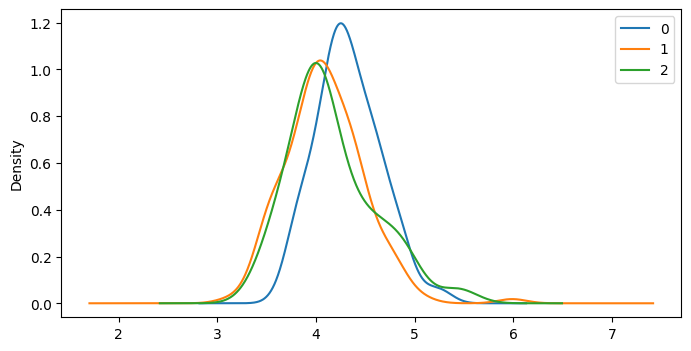

In [9]:
plt.figure(figsize=(8,4))
for i,j in grouped:
    # print(i)
    a=pd.Series(j.mu)
    j.loc[:,'mu'].plot(kind='kde',legend=True,label=str(i))

In [10]:
a=cluster.KMeans(3)
a.fit_predict(sp_cluster.affinity_matrix_)
a.cluster_centers_

array([[6.79300967e-02, 6.79300967e-02, 1.44541105e-04, ...,
        9.31471225e-02, 6.88269313e-01, 2.91226005e-05],
       [1.45316440e-03, 5.86248361e-01, 3.89151200e-02, ...,
        1.05782264e-01, 1.05782264e-01, 3.54859961e-05],
       [1.37160590e-01, 4.54140620e-02, 3.65167983e-02, ...,
        1.30040270e-01, 5.18298376e-02, 1.10844168e-02]])